In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import ndimage
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow import keras
from IPython.display import display 
from PIL import Image
import tensorflow as tf
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns',1000)


In [2]:
train.values.shape

(28709, 2)

In [3]:
# np.asarray(train['feature'].values[i].split(), dtype = int).reshape(48,48)

In [4]:
# train_all = np.zeros((train.values.shape[0],48,48,1))
# for i in range(train.values.shape[0]):
#     train_all[i,:,:,:] = np.asarray(train['feature'].values[i].split(), dtype = int).reshape(48,48,1)


In [5]:
train_all = np.asarray([np.asarray(x.split(), dtype = int).reshape(48,48,1) for x in train['feature'].values])
train_all.shape

(28709, 48, 48, 1)

In [6]:
train_y_all = np.asarray(train['label'].values.reshape((train.values.shape[0],1)),dtype = int)
print(train_y_all.shape)
print(train_all.shape)

(28709, 1)
(28709, 48, 48, 1)


In [7]:
pm = np.random.permutation(train_y_all.shape[0])
t = int(len(pm)*0.7)



In [8]:
# zero-mean
train_all_norm = train_all - int(train_all.mean())

In [9]:
train_x = train_all[pm[0:t],:,:]
train_y = train_y_all[pm[0:t],:]
test_x = train_all[pm[t:len(pm)],:,:]
test_y = train_y_all[pm[t:len(pm)],:]
print(train_x.shape, train_y.shape,test_x.shape, test_y.shape)

(20096, 48, 48, 1) (20096, 1) (8613, 48, 48, 1) (8613, 1)


In [10]:
print(train_x.mean(),test_x.mean())
print(train_x.max(),train_x.min())

129.57770291576128 129.2331703751274
255 0


In [11]:
# display image

# plt.imshow(np.array(train_x[90,:,:,:].reshape(48,48)), cmap=cm.gray)

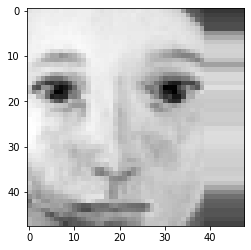

In [12]:
# test
datagen_shift = keras.preprocessing.image.ImageDataGenerator(width_shift_range=[-8,8])
datagen_rotate = keras.preprocessing.image.ImageDataGenerator(rotation_range=30)
datagen_bright = keras.preprocessing.image.ImageDataGenerator(brightness_range=[0.2,1.6])
datagen_zoom = keras.preprocessing.image.ImageDataGenerator(zoom_range=[0.5,1.5])
it_shift = datagen_shift.flow(train_x, train_y,batch_size = 20)
it_rotate = datagen_rotate.flow(train_x, train_y,batch_size = 20)
it_bright = datagen_bright.flow(train_x, train_y,batch_size = 20)
it_zoom = datagen_zoom.flow(train_x, train_y,batch_size = 20)
batch_shift = it_shift.next()
batch_rotate = it_rotate.next()
batch_bright = it_bright.next()
batch_zoom = it_zoom.next()
# print(len(batch)) #1st dim is for x, 2nd dim is for y
# print(len(batch[0])) #list of images, batch_size determines how many images are created
# print(len(batch[0][0]))
# print(len(batch[0][0][0]))
# print(len(batch[0][0][0][0]))

plt.imshow(np.array(batch_shift[0][19].reshape(48,48)), cmap=cm.gray) #batch[0][0] is the first image in the created batch


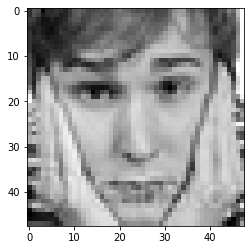

In [13]:
plt.imshow(np.array(batch_bright[0][6].reshape(48,48)), cmap=cm.gray) #batch[0][0] is the first image in the created batch


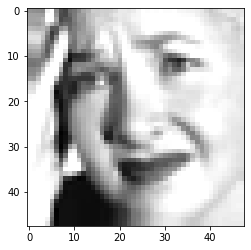

In [14]:
datagen_all = keras.preprocessing.image.ImageDataGenerator(rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               brightness_range=[0.5, 1.5])
it_all = datagen_all.flow(train_x,train_y,batch_size = train_x.shape[0])
batch_all = it_all.next()
plt.imshow(np.array(batch_all[0][0].reshape(48,48)), cmap=cm.gray) #batch[0][0] is the first image in the created batch


In [15]:
epoch = 3
i = 0
train_x_aug = batch_all[0]
train_y_aug = batch_all[1]
while i < epoch:
    i += 1
    batch_all = it_all.next()
    train_x_aug = np.append(train_x_aug, batch_all[0], axis = 0)
    train_y_aug = np.append(train_y_aug, batch_all[1], axis = 0)
train_x_aug.shape

(80384, 48, 48, 1)

In [16]:
train_y_aug.shape


(80384, 1)

In [116]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3)
#                         , padding = 'same'
                        , input_shape=(48, 48, 1)
#                         ,activation = 'relu'
                        ,kernel_initializer='glorot_uniform'
                       ))
# model.add(layers.LeakyReLU())
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3)
#                         ,padding= 'same'
#                         ,activation = 'relu'
                       ))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(1024, (3, 3)
#                         ,padding= 'same'
#                         , activation='relu'
                       ))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128
#                        ,activation = 'relu'
                       , kernel_regularizer=keras.regularizers.l1(0.01)
                      ))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

# model.add(layers.Dropout(0.5))
# model.add(layers.LeakyReLU())
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(7, activation='softmax'
#                        , kernel_regularizer=keras.regularizers.l1(0.01)
                      ))

In [117]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_12 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
re_lu_12 (ReLU)              (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
re_lu_13 (ReLU)              (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 64)       

In [118]:
adam = keras.optimizers.Adam(learning_rate=1, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_x_aug, train_y_aug, batch_size=1024,
                    epochs=5)

Epoch 1/5
80384/80384 [==============================] - 772s 10ms/sample - loss: 30.4514 - acc: 0.2553
Epoch 2/5
80384/80384 [==============================] - 660s 8ms/sample - loss: 7.8908 - acc: 0.2917
Epoch 3/5
80384/80384 [==============================] - 630s 8ms/sample - loss: 7.5387 - acc: 0.3246
Epoch 4/5
80384/80384 [==============================] - 630s 8ms/sample - loss: 7.4727 - acc: 0.3481
Epoch 5/5
80384/80384 [==============================] - 629s 8ms/sample - loss: 7.5341 - acc: 0.3668


In [119]:
test_loss, test_acc = model.evaluate(test_x, test_y)

8613/8613 [==============================] - 13s 2ms/sample - loss: 7.4966 - acc: 0.3747


In [20]:
#========================================================================================================
#====================================try get layer attributes============================================
#========================================================================================================

(48, 48, 1)


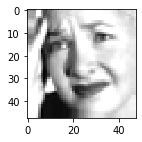

In [96]:
#input print out
print(train_x_aug[0].shape)
plt.figure(figsize=(2,2))
plt.imshow(np.array(train_x_aug[0].reshape(48,48)), cmap=cm.gray) #batch[0][0] is the first image in the created batch


In [105]:

x = train_x_aug[0] #input
b1 = model.get_layer('batch_normalization').output[0] #output of selected layer
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    output1 = sess.run(  b1 , { model.input : train_x_aug[0:6]}  ) 
    print( output1.shape )

(46, 46, 32)


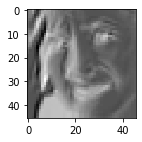

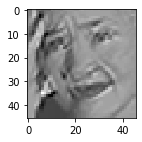

In [98]:
for i in range(2):
    plt.figure(figsize=(2,2))
    plt.imshow(output1[:,:,i], cmap=cm.gray) #batch[0][0] is the first image in the created batch
    plt.show()


In [121]:
# x = model.get_layer('max_pooling2d_8').output #input
b1 = model.get_layer('max_pooling2d_8').output[0] #output of selected layer
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    output = sess.run(  b1 , { model.input : train_x_aug[0:1]}  ) 
    print( output.shape )

(12, 12, 128)


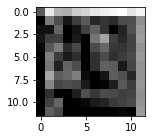

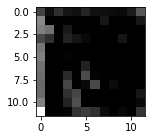

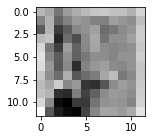

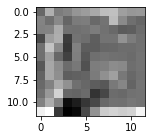

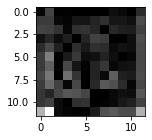

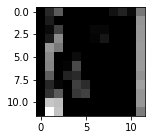

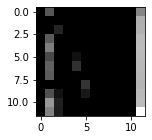

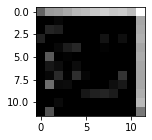

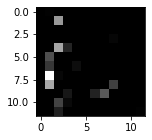

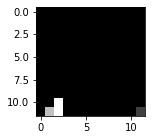

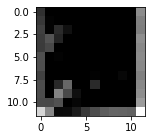

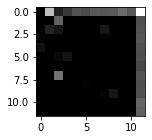

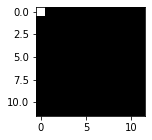

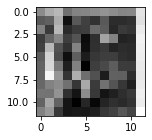

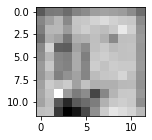

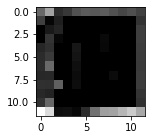

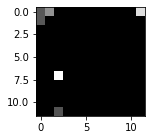

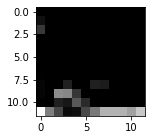

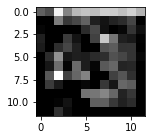

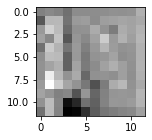

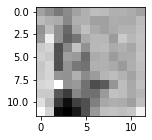

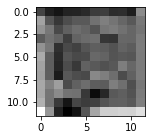

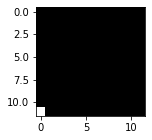

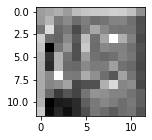

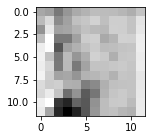

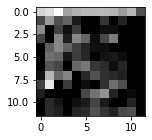

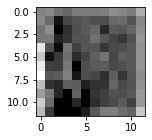

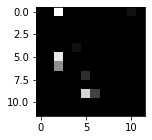

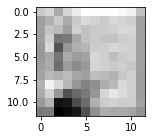

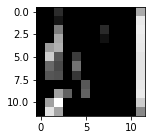

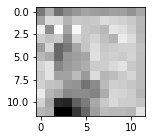

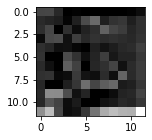

In [122]:
for i in range(32):
    plt.figure(figsize=(2,2))
    plt.imshow(output[:,:,i], cmap=cm.gray) #batch[0][0] is the first image in the created batch
    plt.show()

In [110]:
b2 = model.get_layer('dense_2').input
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    output = sess.run(  b2 , { model.input : train_x_aug[0:1]}  ) 
    print( output.shape )

(1, 12800)


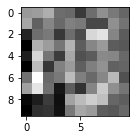

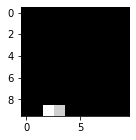

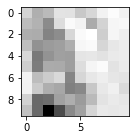

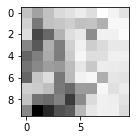

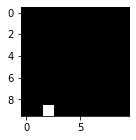

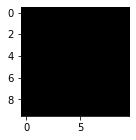

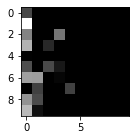

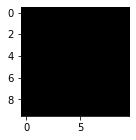

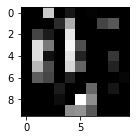

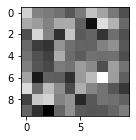

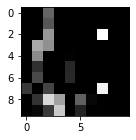

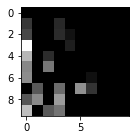

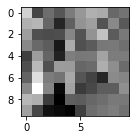

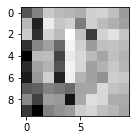

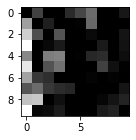

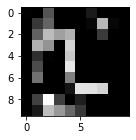

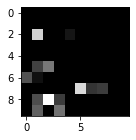

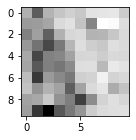

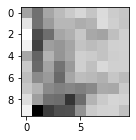

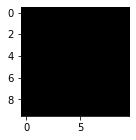

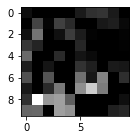

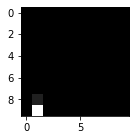

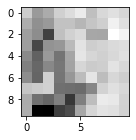

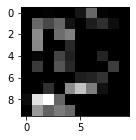

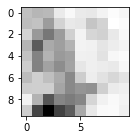

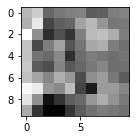

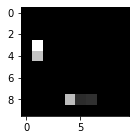

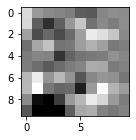

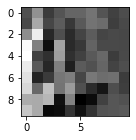

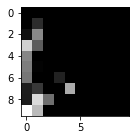

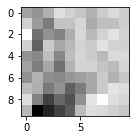

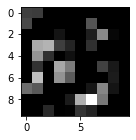

In [112]:
for i in range(32):
    plt.figure(figsize=(2,2))
    plt.imshow(output.reshape(10,10,128)[:,:,i+32], cmap=cm.gray) #batch[0][0] is the first image in the created batch
    plt.show()